In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset2-csv/dataset.csv


# Quantum Machine Learning (QML) Classifiers

This notebook compares a Variational Quantum Classifier (VQC) with classical machine learning models
using standard classification metrics.


Setting up all required libraries and loads the dataset for preprocessing, modeling, and evaluation.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

df = pd.read_csv("/kaggle/input/dataset2-csv/dataset.csv")

Suppresses all warning messages so the notebook output stays clean and uncluttered.

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering
Separates features and target, scales numerical features, compresses binary features using PCA, and combines them into a 4-dimensional, quantum-friendly feature set.

In [22]:
X = df.drop("fraud", axis=1)
y = df["fraud"]

num_cols = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price"
]

bin_cols = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order"
]

# Scale numerical
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_cols])

# Reduce binary → 1 dimension
pca = PCA(n_components=1)
X_bin = pca.fit_transform(X[bin_cols])

# Final quantum-friendly feature set
X_reduced = np.hstack([X_num, X_bin])

# Train/Test Split
Splits the dataset into 80% training and 20% testing while maintaining class balance, and converts labels into NumPy arrays for quantum model compatibility.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train_np = y_train.to_numpy()

# Classical Baseline Models
This cell trains three classical models (Logistic Regression, Random Forest, SVM), evaluates their AUC-ROC and accuracy, and stores predicted probabilities for later analysis.

### 5000 samples are used to train as it takes a lot of time to train 80,000

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced"),
    "SVM": SVC(probability=True)
}

results = {}
probArr =[]

for name, model in models.items():
    model.fit(X_train[:5000], y_train[:5000])
    prob = model.predict_proba(X_test)[:, 1]
    pred = model.predict(X_test)
    results[name] = (
        roc_auc_score(y_test, prob),
        accuracy_score(y_test, pred),
    )
    probArr.append(prob)

This cell extracts the predicted probabilities from the trained models for use in ROC curves and further evaluation.

In [25]:
y_prob_lr = probArr[0]
y_prob_rf = probArr[1]
y_prob_svm = probArr[2]

# Making a Quantum Model 
(using Qiskit)

In [26]:
!pip install qiskit qiskit-machine-learning qiskit-algorithms qiskit-aer

In [27]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit.primitives import StatevectorSampler

This cell sets up the Variational Quantum Classifier (VQC):
* Feature map encodes classical features into a quantum state (ZZFeatureMap).
* Ansatz defines trainable quantum gates (RealAmplitudes).
* VQC is created with a COBYLA optimizer and a statevector simulator sampler.

In [28]:
num_qubits = X_train.shape[1]

feature_map = ZZFeatureMap(num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits, reps=1)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=60),
    sampler=StatevectorSampler()
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


This cell installs the pylatexenc Python package, which is used to render or display LaTeX expressions in notebooks (e.g., for drawing quantum circuits nicely).

In [29]:
!pip install pylatexenc

This cell draws the decomposed quantum circuit of the feature_map using Matplotlib, so you can visualize the actual gates and layers in your ZZFeatureMap.

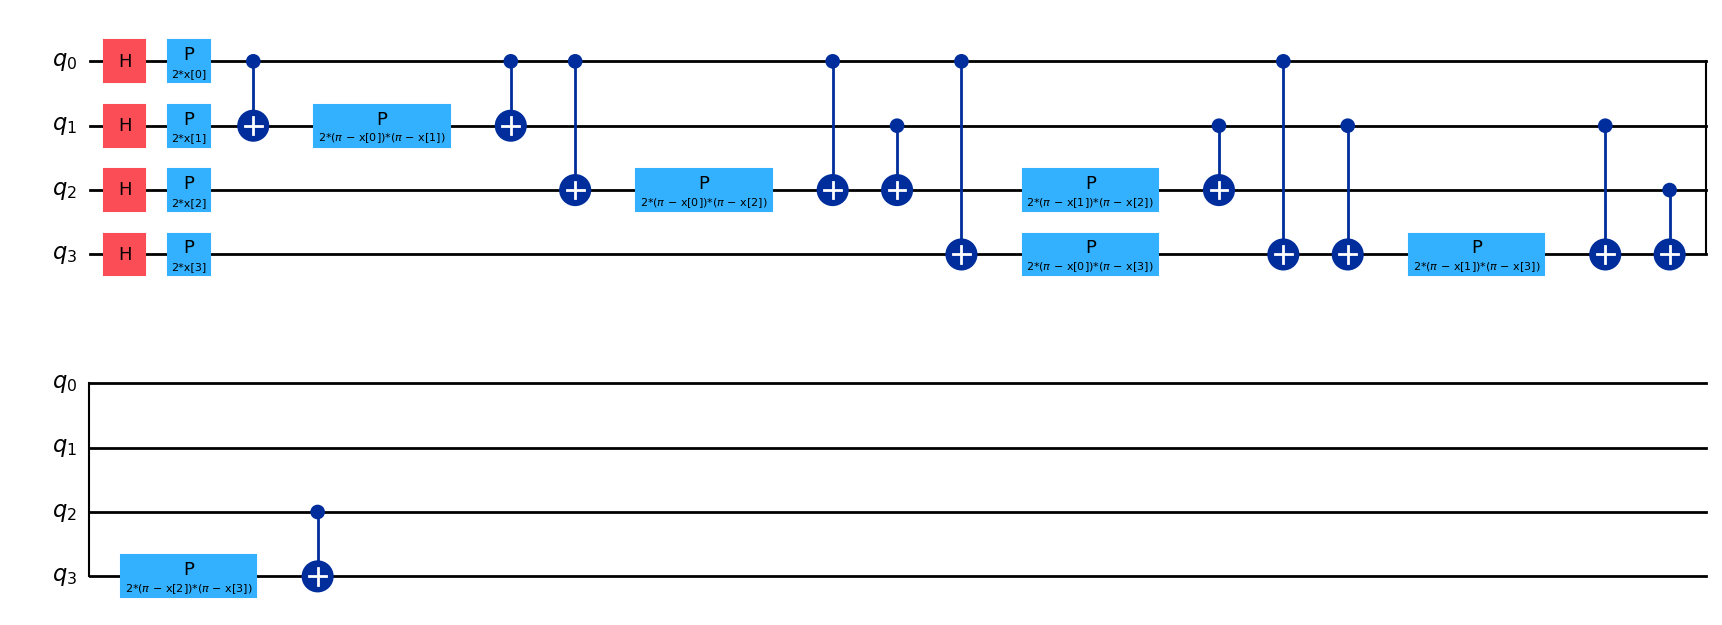

In [30]:
feature_map.decompose().draw("mpl")

This cell visualizes the decomposed ansatz circuit (RealAmplitudes) using Matplotlib, showing all parameterized rotation and entanglement gates in your variational quantum circuit.

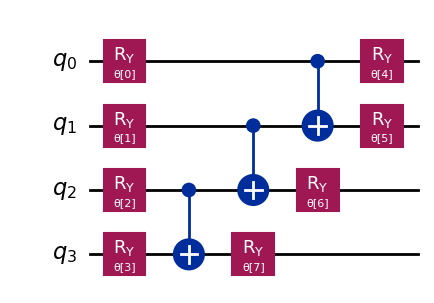

In [31]:
ansatz.decompose().draw("mpl")

This cell trains the VQC on the training dataset (X_train and y_train_np), optimizing the parameters of the ansatz to minimize the classification loss. It may take a while depending on the dataset size and number of qubits.

### 5000 samples are used to train as it takes a lot of time to train 80,000

In [32]:
# Train dataset
vqc.fit(X_train[:5000], y_train_np[:5000])

This cell evaluates the trained VQC on the test samples:
* vqc_prob → predicted probabilities for the positive class.
* vqc_pred → predicted labels using 0.5 threshold.
* Stores AUC-ROC and accuracy for “VQC Ideal” in the results dictionary.

In [33]:
# Evaluate
vqc_prob = vqc.predict_proba(X_test)[:, 1]
vqc_pred = (vqc_prob > 0.5).astype(int)

results["VQC Ideal"] = (
    roc_auc_score(y_test, vqc_prob),
    accuracy_score(y_test, vqc_pred)
)

# Quantum Model (NOISY)

In [34]:
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer

This cell sets up a noisy-simulation VQC:
* Uses Aer simulator with a preset pass manager for transpilation.
* SamplerV2() simulates measurements (introducing realistic noise).
* vqc_noisy is ready for training with the same feature map and ansatz as the ideal VQC.

In [35]:
backend = Aer.get_backend("aer_simulator")
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

vqc_noisy = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=60),
    sampler=SamplerV2(),
    pass_manager=pass_manager
)

This cell trains the noisy VQC on samples and evaluates it:
* vqc_noisy.fit(...) → trains the noisy quantum classifier.
* predict_proba → gets predicted probabilities for the test set.
* noisy_pred → converts probabilities to binary class labels (threshold 0.5).
* Stores AUC-ROC and accuracy in the results dictionary under "VQC Noisy".

In [36]:
vqc_noisy.fit(X_train[:5000], y_train_np[:5000])

noisy_prob = vqc_noisy.predict_proba(X_test)[:, 1]
noisy_pred = (noisy_prob > 0.5).astype(int)

results["VQC Noisy"] = (
    roc_auc_score(y_test, noisy_prob),
    accuracy_score(y_test, noisy_pred)
)

This cell creates a summary table of model performance:
* Converts the results dictionary (with AUC and accuracy) into a pandas DataFrame.
* Rows = models (Logistic Regression, Random Forest, SVM, VQC Ideal, VQC Noisy).
* Columns = metrics (AUC-ROC, Accuracy).
* print(benchmark_df) → displays the table for easy comparison.

In [37]:
benchmark_df = pd.DataFrame(
    results,
    index=["AUC-ROC", "Accuracy"]
).T

print(benchmark_df)

                      AUC-ROC  Accuracy
Logistic Regression  0.957223   0.90720
Random Forest        0.999797   0.99760
SVM                  0.980671   0.95340
VQC Ideal            0.829065   0.83735
VQC Noisy            0.830414   0.84350


# Visualisation

This cell Visualizes model performance, showing how quantum (VQC ideal & noisy) and classical models (LR, RF, SVM) compare on the dataset.

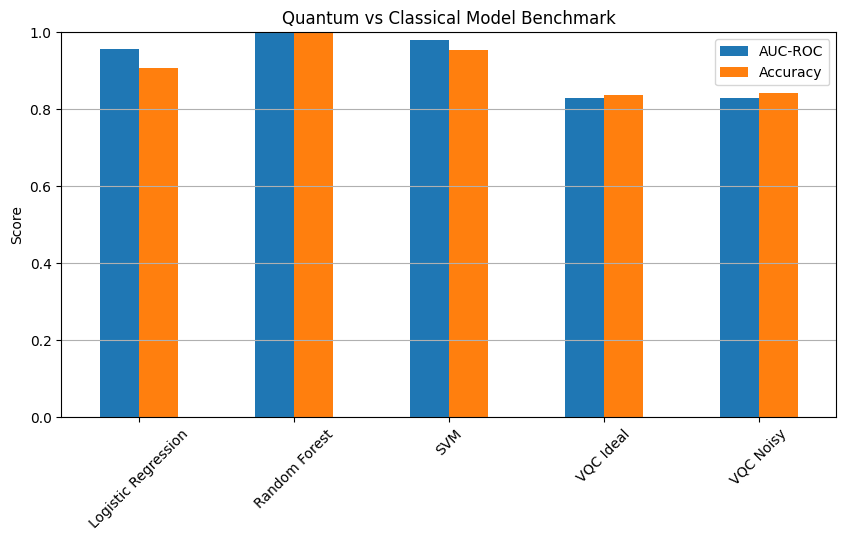

In [38]:
benchmark_df.plot(kind="bar", figsize=(10,5))
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Quantum vs Classical Model Benchmark")
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.show()

This cell plots confusion matrices for both VQC models:

* Ideal VQC → shows how well the perfect quantum model classifies legit vs. fraud transactions.
* Noisy VQC → shows performance under simulated hardware noise.
* ConfusionMatrixDisplay visualizes true positives, false positives, true negatives, and false negatives.

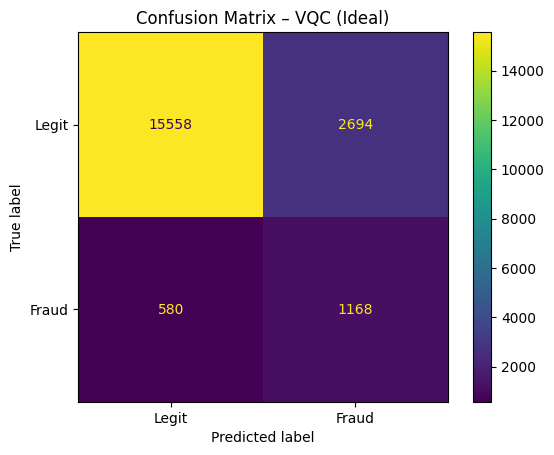

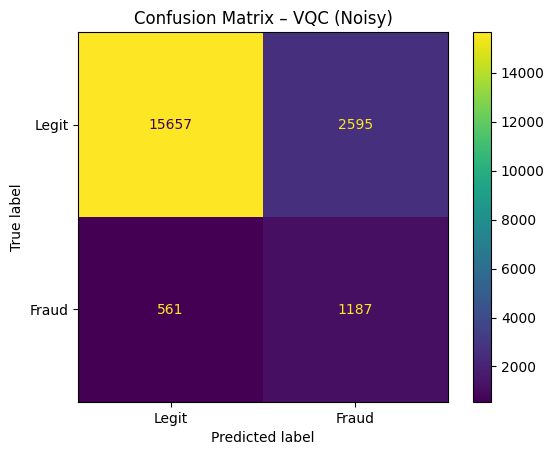

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ideal VQC
y_pred_vqc = vqc.predict(X_test)
cm_vqc = confusion_matrix(y_test, y_pred_vqc)

ConfusionMatrixDisplay(
    cm_vqc,
    display_labels=["Legit", "Fraud"]
).plot()
plt.title("Confusion Matrix – VQC (Ideal)")
plt.show()

# Noisy VQC
y_pred_vqc_noisy = vqc_noisy.predict(X_test)
cm_vqc_noisy = confusion_matrix(y_test, y_pred_vqc_noisy)

ConfusionMatrixDisplay(
    cm_vqc_noisy,
    display_labels=["Legit", "Fraud"]
).plot()
plt.title("Confusion Matrix – VQC (Noisy)")
plt.show()

This cell prints detailed classification reports for both VQC models:

* Shows precision, recall, F1-score, and support for each class (Legit and Fraud).
* Ideal VQC → performance without noise.
* Noisy VQC → performance under simulated hardware noise.
* Helps analyze how well each model distinguishes between classes.

In [40]:
from sklearn.metrics import classification_report

print("Classification Report – VQC (Ideal)")
print(classification_report(
    y_test,
    y_pred_vqc,
    target_names=["Legit", "Fraud"]
))

print("\nClassification Report – VQC (Noisy)")
print(classification_report(
    y_test,
    y_pred_vqc_noisy,
    target_names=["Legit", "Fraud"]
))

Classification Report – VQC (Ideal)
              precision    recall  f1-score   support

       Legit       0.96      0.85      0.90     18252
       Fraud       0.30      0.67      0.42      1748

    accuracy                           0.84     20000
   macro avg       0.63      0.76      0.66     20000
weighted avg       0.91      0.84      0.86     20000


Classification Report – VQC (Noisy)
              precision    recall  f1-score   support

       Legit       0.97      0.86      0.91     18252
       Fraud       0.31      0.68      0.43      1748

    accuracy                           0.84     20000
   macro avg       0.64      0.77      0.67     20000
weighted avg       0.91      0.84      0.87     20000



This cell plots the ROC curves for all models:

* Classical models: Logistic Regression, Random Forest, SVM.
* Quantum models: VQC Ideal and VQC Noisy.
* Purpose: visually compare true positive vs false positive trade-offs and model discrimination ability.
* Diagonal line (k--) represents a random classifier baseline.

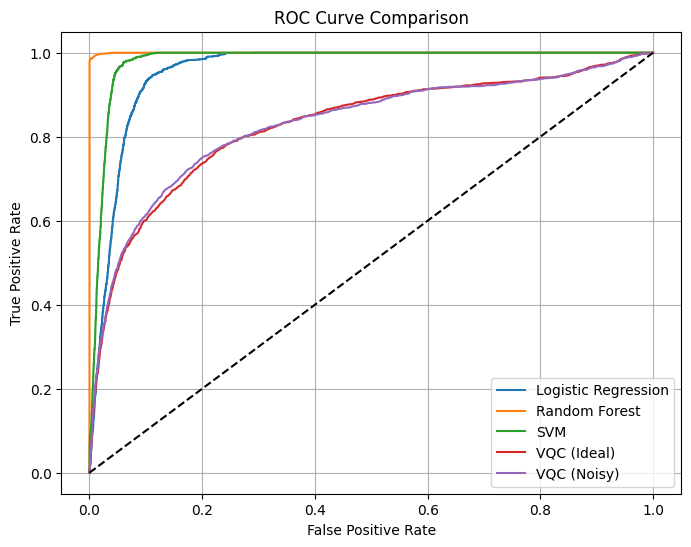

In [41]:
from sklearn.metrics import roc_curve, auc

# Probabilities
vqc_prob = vqc.predict_proba(X_test)[:, 1]
vqc_noisy_prob = vqc_noisy.predict_proba(X_test)[:, 1]

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_vqc, tpr_vqc, _ = roc_curve(y_test, vqc_prob)
fpr_vqc_n, tpr_vqc_n, _ = roc_curve(y_test, vqc_noisy_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_svm, tpr_svm, label="SVM")
plt.plot(fpr_vqc, tpr_vqc, label="VQC (Ideal)")
plt.plot(fpr_vqc_n, tpr_vqc_n, label="VQC (Noisy)")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Using a self chosen Dataset 

## Breast Cancer Dataset

In [42]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Sklearn imports
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [44]:
# Classical models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [45]:
# Qiskit imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit.primitives import StatevectorSampler
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer

## 1. Load & Prepare Dataset

In [46]:
data = load_breast_cancer()
X_2 = data.data
y_2 = data.target

In [47]:
# Scale features
scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X_2)

In [48]:
# Reduce features to 4 for quantum circuit
pca = PCA(n_components=4)
X_reduced_2 = pca.fit_transform(X_scaled_2)

In [49]:
# Train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_reduced_2, y_2, test_size=0.2, stratify=y_2, random_state=42
)
y_train_np_2 = np.array(y_train_2)

## 2. Classical Baseline Models

In [50]:
models_2 = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced"),
    "SVM": SVC(probability=True)
}

results_2 = {}
y_probs_2 = {}

for name, model in models_2.items():
    model.fit(X_train_2, y_train_2)
    prob = model.predict_proba(X_test_2)[:,1]
    pred = model.predict(X_test_2)
    results_2[name] = (roc_auc_score(y_test_2, prob), accuracy_score(y_test_2, pred))
    y_probs_2[name] = prob

## 3. Quantum Models (VQC)

In [51]:
num_qubits_2 = X_train_2.shape[1]

feature_map_2 = ZZFeatureMap(num_qubits_2, reps=1)
ansatz_2 = RealAmplitudes(num_qubits_2, reps=1)

# Ideal VQC
vqc_2 = VQC(
    feature_map=feature_map_2,
    ansatz=ansatz_2,
    optimizer=COBYLA(maxiter=150),
    sampler=StatevectorSampler()
)
vqc_2.fit(X_train_2, y_train_np_2)

vqc_prob_2 = vqc_2.predict_proba(X_test_2)[:,1]
vqc_pred_2 = (vqc_prob_2 > 0.5).astype(int)
results_2["VQC Ideal"] = (roc_auc_score(y_test_2, vqc_prob_2), accuracy_score(y_test_2, vqc_pred_2))

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [52]:
# Noisy VQC
backend_2 = Aer.get_backend("aer_simulator")
pass_manager_2 = generate_preset_pass_manager(optimization_level=1, backend=backend_2)

vqc_noisy_2 = VQC(
    feature_map=feature_map_2,
    ansatz=ansatz_2,
    optimizer=COBYLA(maxiter=150),
    sampler=SamplerV2(),
    pass_manager=pass_manager_2
)
vqc_noisy_2.fit(X_train_2, y_train_np_2)  # small subset for speed

vqc_noisy_prob_2 = vqc_noisy_2.predict_proba(X_test_2)[:,1]
vqc_noisy_pred_2 = (vqc_noisy_prob_2 > 0.5).astype(int)
results_2["VQC Noisy"] = (roc_auc_score(y_test_2, vqc_noisy_prob_2), accuracy_score(y_test_2, vqc_noisy_pred_2))

## 4. Benchmark Table

                      AUC-ROC  Accuracy
Logistic Regression  0.992394  0.938596
Random Forest        0.987103  0.938596
SVM                  0.992725  0.964912
VQC Ideal            0.480655  0.482456
VQC Noisy            0.413690  0.456140


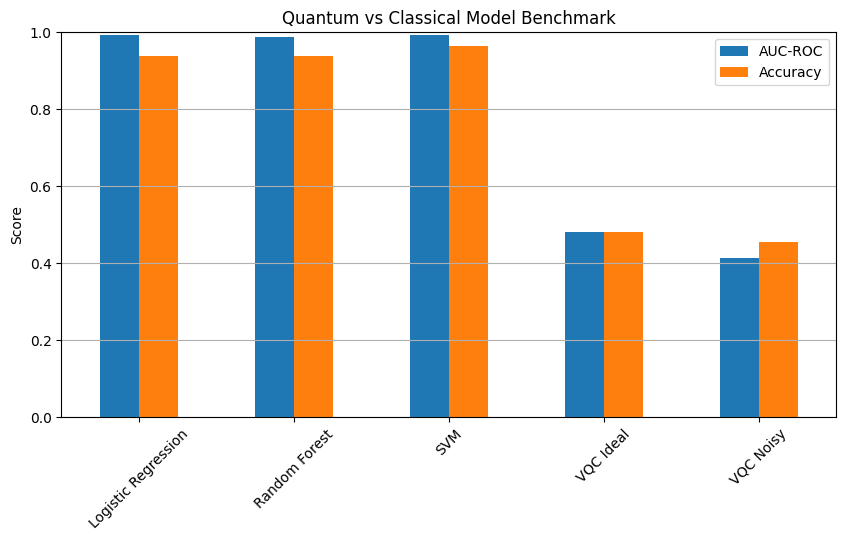

In [53]:
benchmark_df_2 = pd.DataFrame(results_2, index=["AUC-ROC", "Accuracy"]).T
print(benchmark_df_2)

benchmark_df_2.plot(kind="bar", figsize=(10,5))
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Quantum vs Classical Model Benchmark")
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.show()

## 5. Confusion Matrices

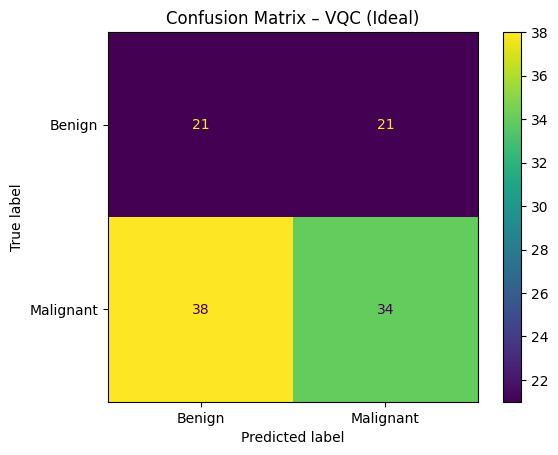

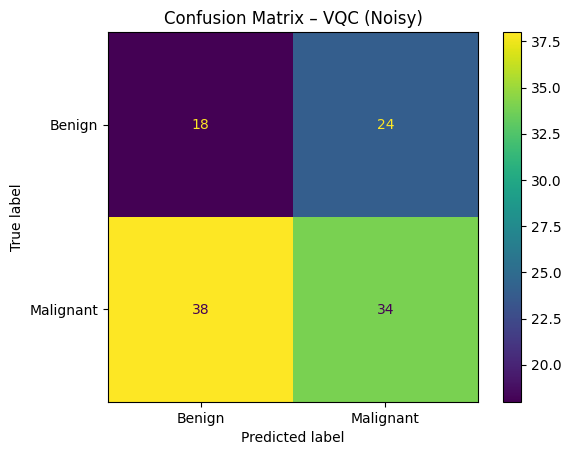

In [54]:
# Ideal VQC
cm_vqc_2 = confusion_matrix(y_test_2, vqc_pred_2)
ConfusionMatrixDisplay(cm_vqc_2, display_labels=["Benign", "Malignant"]).plot()
plt.title("Confusion Matrix – VQC (Ideal)")
plt.show()

# Noisy VQC
cm_vqc_noisy_2 = confusion_matrix(y_test_2, vqc_noisy_pred_2)
ConfusionMatrixDisplay(cm_vqc_noisy_2, display_labels=["Benign", "Malignant"]).plot()
plt.title("Confusion Matrix – VQC (Noisy)")
plt.show()

## 6. Classification Reports

In [55]:
print("Classification Report – VQC (Ideal)")
print(classification_report(y_test_2, vqc_pred_2, target_names=["Benign", "Malignant"]))

print("\nClassification Report – VQC (Noisy)")
print(classification_report(y_test_2, vqc_noisy_pred_2, target_names=["Benign", "Malignant"]))

Classification Report – VQC (Ideal)
              precision    recall  f1-score   support

      Benign       0.36      0.50      0.42        42
   Malignant       0.62      0.47      0.54        72

    accuracy                           0.48       114
   macro avg       0.49      0.49      0.48       114
weighted avg       0.52      0.48      0.49       114


Classification Report – VQC (Noisy)
              precision    recall  f1-score   support

      Benign       0.32      0.43      0.37        42
   Malignant       0.59      0.47      0.52        72

    accuracy                           0.46       114
   macro avg       0.45      0.45      0.45       114
weighted avg       0.49      0.46      0.47       114



## 7. ROC Curve Comparison

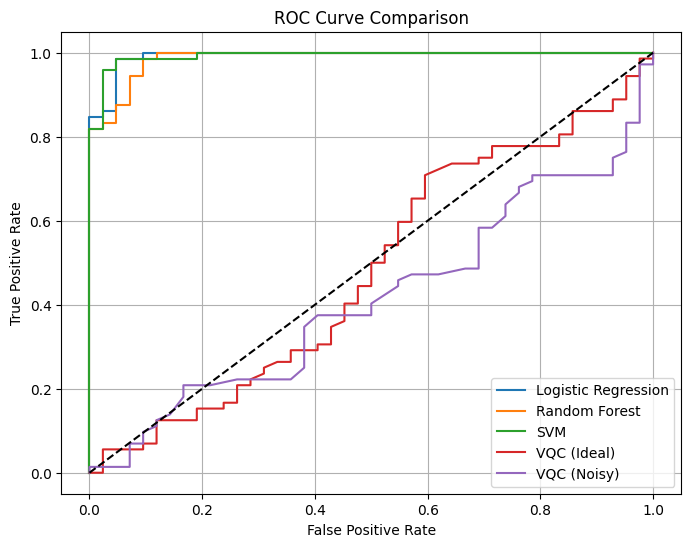

In [56]:

fpr_lr_2, tpr_lr_2, _ = roc_curve(y_test_2, y_probs_2["Logistic Regression"])
fpr_rf_2, tpr_rf_2, _ = roc_curve(y_test_2, y_probs_2["Random Forest"])
fpr_svm_2, tpr_svm_2, _ = roc_curve(y_test_2, y_probs_2["SVM"])
fpr_vqc_2, tpr_vqc_2, _ = roc_curve(y_test_2, vqc_prob_2)
fpr_vqc_n_2, tpr_vqc_n_2, _ = roc_curve(y_test_2, vqc_noisy_prob_2)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr_2, tpr_lr_2, label="Logistic Regression")
plt.plot(fpr_rf_2, tpr_rf_2, label="Random Forest")
plt.plot(fpr_svm_2, tpr_svm_2, label="SVM")
plt.plot(fpr_vqc_2, tpr_vqc_2, label="VQC (Ideal)")
plt.plot(fpr_vqc_n_2, tpr_vqc_n_2, label="VQC (Noisy)")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## While classical models outperform the VQC on this dataset, this behavior is expected due to the dataset’s strong linear separability and limited quantum model capacity. The experiment demonstrates the practical challenges of training variational quantum classifiers under NISQ constraints, particularly sensitivity to noise and limited expressivity. These results highlight that current quantum models are better suited for low-data or highly non-linear regimes rather than well-conditioned classical benchmarks.